In [1]:
import config
import os, numpy as np, pandas, sklearn
import mido
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
## NN libs
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.preprocessing import RobustScaler
import keras
from keras import regularizers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.optimizers import SGD, Adam
from keras.layers import Input, Dense, Activation, Conv1D, Conv2D, Dropout, Flatten
from keras.layers import Conv2DTranspose, Reshape, MaxPooling2D, UpSampling2D, UpSampling1D, MaxPooling1D
from keras.layers import LocallyConnected1D, LocallyConnected2D
from keras.layers import Input, LSTM, RepeatVector
from keras.models import Model
from keras.callbacks import TensorBoard

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
# local libs
import config, models, functions
from data import data, midi, midi_generators as g
from utils import io, models_io

 Context :: namedtuple(
[ max_t = float
, dt = float
, n_instances = int
, note_length = int
, bpm = float
, tempo = float
, ticks_per_beat = int
]



In [4]:
context = data.init()

Setting up params

max min f 25.0 0.1
 >> Context(max_t=10.0, dt=0.02, n_instances=500, note_length=0.03, bpm=120.0, tempo=500000, ticks_per_beat=480)


In [5]:
# fn = (config.dataset_dir + '4-floor-120bpm.mid')
# mid = io.import_midifile(fn)

## Setup a generator

1. What is the least amount of 'hidden' nodes needed to learn a straight rythm (e.g. 8th notes with different frequencies)
2. Can we create a model of a generic function sin(2 pi f t + phase)
    - using x: t -> y: sin(2p t)
    - using x: [f, t, phase] -> y: sin(2p f t + phase)
    - using x: sin([t1, t2, t3) -> y: [f, t, phase]
        - such a model should be able to learn complex patterns, such as sin(f1+p1) + sin(f2+p2) + sin(f3+p3)

In [6]:
n = 100
max_f = 12
min_f = 10
x_train = g.gen_data(context, n, max_f=max_f, min_f=min_f)
# x_train = np.zeros([10,100,127])
y_train = x_train

WARNING type not == 0
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  10.006249999999977
 |>  500
WARNING type not == 0
WARNING type not == 0
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  9.999999999999998
 |>  500
WARNING type not == 0
WARNING type not == 0
WARNING type not == 0
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  10.00624999999996
 |>  500
WARNING type not == 0
WARNING type not == 0
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  9.996875000000012
 |>  500
WARNING type not == 0
WARNING type not == 0
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  10.016666666666653
 |>  500
WARNING type not == 0
WARNING type not == 0
WARNING type not == 0
WARNING type not == 0
WARNING type not == 0
WARNING type not == 0
WARNING type not == 0
WARNING type not == 0
WARNING type not == 0
WARNING type not == 0
WARNING type not == 0
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  9.999999999999982
 |>  500
WARNING type not == 0
 [DEBUG] > 
 |>  to_ar

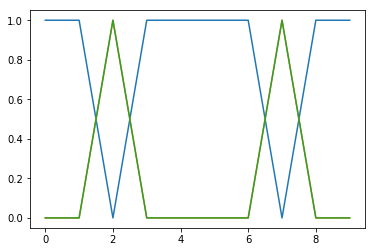

In [7]:
plt.plot(x_train[0,:10,0:3])

In [8]:
# [sum(x) for x in x_train]
x_train.shape

(100, 500, 5)

In [9]:
y_train = x_train
n_samples = x_train[0]
input_shape = x_train.shape[1:] # shape of a single sample
output_shape = y_train.shape[1:]
# output_length = y_train.shape[1]
# output_length = (y_train[0]).shape[0] # = length of an individual label
hidden_layer_length = 100
x_train.shape

(100, 500, 5)

In [10]:
# functional syntax: lambda x: lambda y: z
def encoder(input_shape, output_length, dropout=0.10):
    input_layer = Input(shape=input_shape)
    x = input_layer
    x = Flatten()(x)
    x = Dense(output_length * 2, activation='relu')(x)    
    x = Dropout(dropout)(x)
    x = Dense(output_length * 2, activation='relu')(x)
    x = Dense(output_length, activation='relu')(x)
    x = Dense(output_length, activation='sigmoid')(x)
    x = Dropout(dropout)(x)
#     x = Dense(output_length, activation='relu', activity_regularizer=regularizers.l1(10e-5))(x)
    #     model.add(Dropout(dropout))    
    model = Model(inputs=input_layer, outputs=x)
    return model


def decoder(input_length, output_shape, dropout=0.10):
    input_layer = Input(shape=(input_length,))
    x = input_layer
    shape = output_shape
    # shape = (10,100) # increase n dimensions
    
    x = Dense(np.prod(shape), activation='relu')(x)
    x = Dropout(dropout)(x)
    x = Dense(np.prod(shape), activation='relu')(x)
    x = Dropout(dropout)(x)
    x = Dense(np.prod(shape), activation='sigmoid')(x) # 4*4*8 = 128
    x = Reshape(shape)(x)
#     x = UpSampling1D(10)(x)
    # make sure the conv layer increases the amount of dimensions
#     dims = keras.backend.int_shape(x)[1:]
#     n_steps = output_shape[0]
#     n_output_timesteps = output_shape[1]
#     filters = n_output_timesteps
#     conv_amt = 2
#     print('__+++==', n_output_timesteps)
#     x = Conv1D(filters, kernel_size=4, strides=2, activation='relu')(x) # 50,100

    dims = keras.backend.int_shape(x)[1:]
#     x = UpSampling1D(dims[0] * 2)(x)
#     x = Dense(output_shape[1], activation='relu')(x)
    #     x = LocallyConnected1D(output_shape[1], kernel_size=1, activation='relu')(x)
    # x = Dense(output_length, activation='softmax')(x)
    model = Model(inputs=input_layer, outputs=x)
    #     model.add(Dropout(dropout))
    return model


def autoencoder(input_shape, output_shape, hidden_layer_length=10, dropout=0.10, verbose=False):
    input_ = Input(shape=input_shape)
    encode = encoder(input_shape, hidden_layer_length, dropout)
    if verbose:
        encode.summary()
    decode = decoder(hidden_layer_length, output_shape, dropout)
    if verbose:
        decode.summary()
    model = Model(input_, decode(encode(input_)))
    return encode, decode, model

dropout = 0.1
encoder, decoder, auto = autoencoder(input_shape, output_shape, hidden_layer_length, dropout, True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 500, 5)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2500)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               500200    
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
__________

In [11]:
metrics = ['accuracy','mse','mae']
loss = 'binary_crossentropy'# binary_crossentropy categorical_crossentropy
optimizer = 'adadelta'
auto.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [12]:
batch_size = 16
# n epochs = n iterations over all the training data
epochs = 50

In [13]:
# history = auto.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, callbacks=[TensorBoard(log_dir=config.tmp_log_dir)])
history = auto.fit(x_train, y_train, epochs=epochs, batch_size=batch_size,
          validation_split=1/6, callbacks=[TensorBoard(log_dir=config.tmp_log_dir)])

Train on 83 samples, validate on 17 samples
Epoch 1/50
83/83 [==============================] - 3s 33ms/step - loss: 0.6935 - acc: 0.5064 - mean_squared_error: 0.2502 - mean_absolute_error: 0.4998 - val_loss: 0.6906 - val_acc: 0.5386 - val_mean_squared_error: 0.2487 - val_mean_absolute_error: 0.4985
Epoch 2/50
83/83 [==============================] - 2s 28ms/step - loss: 0.6894 - acc: 0.5468 - mean_squared_error: 0.2481 - mean_absolute_error: 0.4977 - val_loss: 0.6866 - val_acc: 0.5745 - val_mean_squared_error: 0.2468 - val_mean_absolute_error: 0.4964
Epoch 3/50
83/83 [==============================] - 2s 27ms/step - loss: 0.6849 - acc: 0.5843 - mean_squared_error: 0.2459 - mean_absolute_error: 0.4953 - val_loss: 0.6817 - val_acc: 0.6086 - val_mean_squared_error: 0.2443 - val_mean_absolute_error: 0.4937
Epoch 4/50
83/83 [==============================] - 2s 27ms/step - loss: 0.6792 - acc: 0.6166 - mean_squared_error: 0.2431 - mean_absolute_error: 0.4922 - val_loss: 0.6750 - val_acc: 0.

Epoch 33/50
83/83 [==============================] - 2s 26ms/step - loss: 0.5574 - acc: 0.7520 - mean_squared_error: 0.1856 - mean_absolute_error: 0.3702 - val_loss: 0.5731 - val_acc: 0.7449 - val_mean_squared_error: 0.1918 - val_mean_absolute_error: 0.3767
Epoch 34/50
83/83 [==============================] - 2s 26ms/step - loss: 0.5573 - acc: 0.7521 - mean_squared_error: 0.1855 - mean_absolute_error: 0.3704 - val_loss: 0.5734 - val_acc: 0.7449 - val_mean_squared_error: 0.1920 - val_mean_absolute_error: 0.3784
Epoch 35/50
83/83 [==============================] - 2s 26ms/step - loss: 0.5573 - acc: 0.7520 - mean_squared_error: 0.1856 - mean_absolute_error: 0.3720 - val_loss: 0.5747 - val_acc: 0.7449 - val_mean_squared_error: 0.1923 - val_mean_absolute_error: 0.3741
Epoch 36/50
83/83 [==============================] - 2s 30ms/step - loss: 0.5567 - acc: 0.7520 - mean_squared_error: 0.1853 - mean_absolute_error: 0.3685 - val_loss: 0.5742 - val_acc: 0.7449 - val_mean_squared_error: 0.1922 - 

(0, 0.7003713174038623)

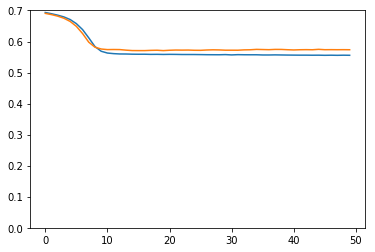

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylim(ymin=0)

In [15]:
history.history.keys()

dict_keys(['val_loss', 'val_acc', 'val_mean_squared_error', 'val_mean_absolute_error', 'loss', 'acc', 'mean_squared_error', 'mean_absolute_error'])

(0, 1)

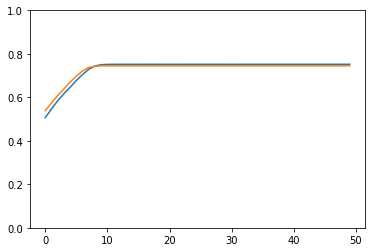

In [16]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylim(ymin=0, ymax=1)

In [17]:
mid1 = g.render_midi(context, f=2)
mid2 = g.render_midi(context, f=3)
x_test = np.stack([midi.encode(context, m) for m in [mid1,mid2]])

WARNING type not == 0
WARNING type not == 0


In [18]:
# maxx = np.maximum(latent[0],latent[1])
# maxx.shape

In [19]:
# arrays = decoder.predict(np.stack([latent[1]]))
arrays = auto.predict(x_train[:1])
arrays.shape

(1, 500, 5)

In [20]:
arrays.max()

0.90600616

(0, 1)

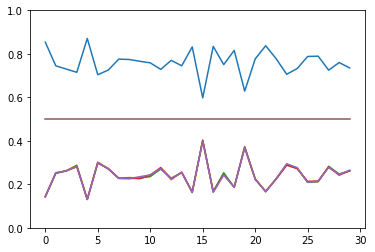

In [30]:
n1 = 30
plt.plot(arrays[0, :n1, 0:])
plt.plot([0.5] * n1) # midi.MIDI_NOISE_FLOOR
plt.ylim(ymin=0, ymax=1)

(0, 1)

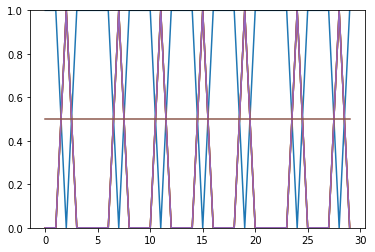

In [32]:
plt.plot(x_train[0, :n1, 0:])
plt.plot([0.5] * n1) # midi.MIDI_NOISE_FLOOR
plt.ylim(ymin=0, ymax=1)

In [23]:
mid = midi.decode_track(context, arrays[0])

 [INFO] : 
 |  len, max_t
 |  0
 |  10.0


In [24]:
dn = config.export_dir
io.export_midifile(mid1, dn + 'mid1.mid')
# io.export_midifile(mid2, dn + 'mid2.mid')
io.export_midifile(mid, dn + 'mid_generated.mid')

In [25]:
mid

<midi file None type 1, 1 tracks, 0 messages>

In [26]:
mid

<midi file None type 1, 1 tracks, 0 messages>